<a href="https://colab.research.google.com/github/keresztesbeata/Intelligent-Systems-Lab/blob/main/Restaurant-Reviews-NLP/RestaurantReviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Restaurant Reviews

## Context
Analyzing the positive and negative reviews of a customers/guests related to a restaurant (or any other service) could help to estimate the success and popularity of the restaurant, estimate its future profits or highlight the areas that need to be changed in order to accommodate to the needs and expectations of the customers.

Automatically categorizing these reviews as positive or negative, without the need to read and interpret them one-by-one (nearly impossible for millions of reviews), could improve the efficiency of such review system, by speeding up the process of evaluating the customer feedback and adjusting the provided services.

The task of categorizing such reviews belongs to the domain of Natural Language Processing, more specifically Sentiment Analysis based on a text fragment.

## Dataset
The dataset consists of a file containing 2 columns, one with the actual customer reviews and the second, a label indicating whether the customer has liked the food offered by the restaurant or not.

## Task
Decide if a given review is positive or negative.

# Data preparation

In [166]:
import numpy as np 
import pandas as pd
import seaborn as sns
import plotly.express as px
from sklearn.base import clone
import csv

import tensorflow as tf
from tensorflow import keras
from keras.layers import Embedding, LSTM, Dense, Bidirectional, GlobalAveragePooling1D, Conv1D, Dropout
from keras.models import Sequential, Model

from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical

from keras import initializers as initializers, regularizers, constraints

from sklearn.model_selection import train_test_split
import string
from sklearn.feature_extraction.text import CountVectorizer

from nltk.stem.porter import PorterStemmer
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Define helper function for plotting graphs:

In [167]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

## Reading the data

In [168]:
data_url = "https://raw.githubusercontent.com/keresztesbeata/Intelligent-Systems-Lab/main/Restaurant-Reviews-NLP/restaurant_reviews_data.csv"

raw_data = pd.read_csv(data_url, on_bad_lines='skip')

In [169]:
raw_data.head()

,Review,Liked
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


In [170]:
raw_data.groupby('Liked').describe()

Review                                    
       count unique                     top freq
Liked                                           
0        500    497  The food was terrible.    2
1        500    499      I love this place.    2

As we can see the dataset is quite balanced, there are almost as many positive as negative examples of reviews which will be helpful when training the model as there is less danger of overfitting our model.

In [171]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  1000 non-null   object
 1   Liked   1000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 15.8+ KB


Check if there are any null values:

In [172]:
raw_data.isnull().sum()

Review    0
Liked     0
dtype: int64

Remove the duplicates:

In [173]:
raw_data = raw_data.drop_duplicates()
raw_data.groupby('Liked').describe()

Review                                      
       count unique                       top freq
Liked                                             
0        497    497        Crust is not good.    1
1        499    499  Wow... Loved this place.    1

## Preparing the data

Before feeding the input data to our model, it must be cleaned and prepared and a vocabulary has to be built from it, which will be later used by an Embedding layer as part of the CNN model.

### Text Preprocessing

Clean the dataset with the following steps:
- transform all the words in the text to lowercase;
- split the text into words (tokens) based on the white space characters;
- remove punctuation marks, as they do not have a relevance in this case;
- stemming the words (remove suffixes such as "ing", "ly", "es", "s" from a word to obtain the root word);
- remove the words which contain non-merical or special characters and keep only the ones which contain excluseilevy alphabetical characters;
- remove 'stop words', the most common words, articles, pronouns in English, for ex. a, an, the, and, if, then, etc;
- Remove words with length of 0 or just 1 character.

In [238]:
def cleaning_text(text):
    """
      Clean and standardize the given text by applying some transformation steps 
      on it in order to obtain a format which can be fed to the model later.
      Steps:
      - standardization: preprocessing (lowercase, remove punctuations, stopwords)
      - tokenization: split the strings into tokens

      Returns:
        a list of words with standard ('clean') format
    """
    # transform the text to lowercase
    text = text.lower()
    
    # split the data into an array of words (= tokens delimeted by space)
    words = text.split(' ')

    # remove all punctuation marks
    words = [word.translate(string.punctuation) for word in words if word]

    # keep only the words which contain only alpahebtic characters
    words = [word for word in words if word.isalpha()]

    # similarly, filter stop words:
    excluded_words = stopwords.words('english')

    # keep 'not' because it will be used to identify the negative reviews
    excluded_words.remove("not")
    
    # stemming the suffixes of aggregate words to obtain the root word
    ps = PorterStemmer()
    words = [ps.stem(word) for word in words if not word in excluded_words]

    # finally, filter the words by a min length, which should be at least 2 characters
    words = [word for word in words if len(word) > 1]

    return words

Clean each review in the dataset and collect them to a list:

In [175]:
def cleaning_data(text_data):
  corpus = []

  for col, row in text_data.items():
    # clean the next entry (standardization)
    cleaned_text = cleaning_text(row)
    # join the list of words back into a sentence
    cleaned_text = " ".join(cleaned_text)
    # add the cleaned text to the vocabulary
    corpus.append(cleaned_text)

  return corpus

In [176]:
# create a 'cleaned' copy of the original dataset
clean_data = raw_data.copy()
clean_data['Review'] = cleaning_data(raw_data['Review'])
# show preview
clean_data.head()

,Review,Liked
0,love,1
1,crust not,0
2,not tasti textur,0
3,stop late may bank holiday rick steve recommen...,1
4,select menu great,1


### Text Encoding

In [177]:
# extract a sample set from the preprocessed data to exempify the text vectorization process
sample = clean_data['Review'].head()

# <OOV> marks Out-of-Vocabulary tokens which cannot be recognized
tokenizer = Tokenizer(num_words=100, oov_token="<OOV>")
# apply the tokenizer on the cleaned input texts
tokenizer.fit_on_texts(sample)
word_index = tokenizer.word_index

print("The unique words found in the sample text together with their associated index value:")
print(word_index)
print("----------------------------------------------------------------------")

# generate encoded sequences from the texts using the word_index values
sequences = tokenizer.texts_to_sequences(sample)
# pad the sequences to ensure each of them has the same length (post padding)
padded = pad_sequences(sequences, maxlen=10, padding='post')

for i in range(0,4):
  print("Original sentence: ", sample[i])
  print("Sequences: ", sequences[i])
  print("Post padded sequences to fixed length of 10: ", padded[i])
  print("----------------------------------------------------------------------")

The unique words found in the sample text together with their associated index value:
{'<OOV>': 1, 'love': 2, 'not': 3, 'crust': 4, 'tasti': 5, 'textur': 6, 'stop': 7, 'late': 8, 'may': 9, 'bank': 10, 'holiday': 11, 'rick': 12, 'steve': 13, 'recommend': 14, 'select': 15, 'menu': 16, 'great': 17}
----------------------------------------------------------------------
Original sentence:  love
Sequences:  [2]
Post padded sequences to fixed length of 10:  [2 0 0 0 0 0 0 0 0 0]
----------------------------------------------------------------------
Original sentence:  crust not
Sequences:  [4, 3]
Post padded sequences to fixed length of 10:  [4 3 0 0 0 0 0 0 0 0]
----------------------------------------------------------------------
Original sentence:  not tasti textur
Sequences:  [3, 5, 6]
Post padded sequences to fixed length of 10:  [3 5 6 0 0 0 0 0 0 0]
----------------------------------------------------------------------
Original sentence:  stop late may bank holiday rick steve recommen

#### Bag-of-Words models (BoW):

Create a _dicitionary_ representing the universe of words contained in the corpus of the cleaned review texts. Using the dictionary and the stemmed tokens, we can create a BoW model which identifies each unique token (word) and its frequency or number of occurances in all the texts.

In [178]:
VOCAB_SIZE = raw_data.shape[0]

cv = CountVectorizer(max_features = VOCAB_SIZE) #  the maximum size of sparse matrix

# create a 2D array (matrix) marking the nr of occurances of each word (token) in each of the reviews
X = cv.fit_transform(cleaning_data(raw_data['Review'])).toarray()
# extract the output labels (from the last column which is 'Liked')
y = raw_data.iloc[:,-1].values 

freq_vector = pd.DataFrame(X, columns=cv.get_feature_names())

# display the first few rows to show the format of the matrix
freq_vector.head()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,absolut,absolutley,accid,accommod,accomod,account,ach,actual,ad,afford,...,yama,yay,year,yellow,yellowtail,yet,yukon,yum,yummi,zero
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Build a custom text cleaner&encoder for the Embedding layer

Apply on the input data the following steps:
 - cleaning
 - tokenization
 - assigning each token/word a unique index and adding it to the vocabulary
 - generating a sequence of labels for the original text
 - padding to obtain sequences of equal length

In [179]:
def preprocessing_layer(data, max_length = 256):
    """
      Preprocessing layer applied on the input data:
      - clean the text present in the 'Review' column
      - tokenize the cleaned sequences and collect them into a vocabulary

      data = input data
      max_length = maximum words in a sentence
      max_features = ensures that only the most frequent words are stored in
      the vocabulary
    """
    clean_data = data.copy()
    clean_data['Review'] = cleaning_data(data['Review'])

    reviews = clean_data['Review']

    # tokenize the cleaned text into words
    tokenizer = Tokenizer()

    # update the internal vocabulary based on a list of texts:
    #  -> vocab index based on word frequency: vocab["dog"] = 2
    #      { index = word,
    #        value = frequency of the word }
    tokenizer.fit_on_texts(reviews)

    # Find the maximum number of unique words in the vocabulary
    max_features = len(tokenizer.word_index) + 1 

    # truncate the text to fit into sequences of fixed length
    sequences = tokenizer.texts_to_sequences(reviews)
    # if the length of the text is smaller than the predefined length of 
    # a sequence, then apply padding
    padded = pad_sequences(sequences, maxlen=max_length, padding='post')

    clean_data['Review'] = padded

    return clean_data, word_index

### Using Keras Text Vectorization

Using the TextVectorization layer from keras, it allows us to combine the text preprocessing and encoding steps:

In [180]:
def text_vectorization_layer(vocab_data, vocab_size, sequence_length, custom=False):
    """
      It analyzes the given dataset, determine the frequency of individual words
      and create a vocabulary from them.

      Applies a processing layer for text:
        - clean/standardize each example: lowercase + remove punctuation
        - split it into tokens (words)
        - rejoin substrings into token expressions
        - index tokens

        Params:
        - vocab_data: the text to be cleaned
        - vocab_size: the vocabulary size (max features) ex. 1000
        - sequence_length: fixed length for sequences (pad or truncate if necessary) ex. 250
        - custom: indicate whether to use the custom standardization function or the defualt one
    """
    custom_encoder = tf.keras.layers.TextVectorization(
        # replace the default standardization layer with our custom layer
        standardize = cleaning_text, 
        max_tokens=vocab_size,
        output_mode='int',
        output_sequence_length=sequence_length)

    default_encoder = tf.keras.layers.TextVectorization(
        standardize = 'lower_and_strip_punctuation',
        split='whitespace',
        max_tokens=vocab_size,
        output_mode='int',
        output_sequence_length=sequence_length)
    
    encoder = custom_encoder if custom else default_encoder

    # Make a text-only dataset (without labels), then call adapt on it
    encoder.adapt(vocab_data.map(lambda review,liked : review))

    return encoder

Define a function which is able to convert the dataset stored in a pandas dataframe into a tensorflow dataset, which can be later used as input for the RNN model's layer.

In [181]:
def convert_to_tf(pd_data):
  """
    Converts a pandas dataframe to a tensorflow dataset.
  """
  tf_data = tf.data.Dataset.from_tensor_slices(dict(raw_data))
  
  return tf_data.map(lambda row : (row['Review'], row['Liked']))

In [182]:
# test the conversion function
ds = convert_to_tf(raw_data)

for review, liked in ds.take(1):
  print(review.numpy())
  print(liked.numpy())

b'Wow... Loved this place.'
1


Shuffle the data for training and create batches of (text, label):

In [183]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_ds = ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

Check that the review-liked pair of values appear correctly in the dataset:

In [184]:
for review, liked in train_ds.take(1):
  print('review: ', review.numpy()[:3])
  print()
  print('liked: ', liked.numpy()[:3])

review:  [b'Great place to relax and have an awesome burger and beer.'
 b'The problem I have is that they charge $11.99 for a sandwich that is no bigger than a Subway sub (which offers better and more amount of vegetables).'
 b'These were so good we ordered them twice.']

liked:  [1 0 1]


Test the TextVectorization layer from keras on a subset of the training set:

In [185]:
VOCAB_SIZE = raw_data.shape[0]
max_sequence_length = 10

# get the predefined encoder
encoder = text_vectorization_layer(train_ds, VOCAB_SIZE, max_sequence_length)
# retrieve the created vocabulary by the encoder
vocab = np.array(encoder.get_vocabulary())
# display the first 10 vocabulary entries: words and their encodings
sample_size = 10
print("The first ", sample_size, " entries in the vocabulary and their corresponding sequence encodings are: ")
for i in range(1,sample_size):
  print(vocab[i], " - ", encoder(vocab[i]).numpy())

The first  10  entries in the vocabulary and their corresponding sequence encodings are: 
[UNK]  -  [1 0 0 0 0 0 0 0 0 0]
the  -  [2 0 0 0 0 0 0 0 0 0]
and  -  [3 0 0 0 0 0 0 0 0 0]
i  -  [4 0 0 0 0 0 0 0 0 0]
was  -  [5 0 0 0 0 0 0 0 0 0]
a  -  [6 0 0 0 0 0 0 0 0 0]
to  -  [7 0 0 0 0 0 0 0 0 0]
is  -  [8 0 0 0 0 0 0 0 0 0]
this  -  [9 0 0 0 0 0 0 0 0 0]


Wrapper function for preparing the data to be used as tensorflow dataset:

In [213]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

def wrap_tf_dataset(data, shuffle=False, buffer_size=BUFFER_SIZE, bath_size=BATCH_SIZE):

  tf_data = convert_to_tf(data)

  if(shuffle):
    # shuffle the data for training and create batches of (text, label):
    tf_data = tf_data.shuffle(BUFFER_SIZE)
  
  # the test data doesn't need to be shuffled
  tf_data = tf_data.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

  return tf_data

## Splitting the dataset into train and validation sets

Splitting the data into train and test sets ensures that the model is not biased when predicting the output label.

The dataset will be split in 8/2 ratio, using 80% of the available data as train data, and the remaining 20% will be used for evaluation (test set).

The training set will be further split in an 9/1 ratio to obtain a smaller validation set.

* training set: 70% 
* validation set: 10%
* test set: 20%

In [187]:
def split_dataset(X, y, test_split = 0.2, validation_split=0.1):
  # split the initial dataset into training and test sets
  X_int, X_test, y_int, y_test = train_test_split(X, y, test_size=test_split, random_state=42)
  # split the training dataset further to obtain a validation set
  X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=validation_split, random_state=42)
  
  return [(X_train, y_train), (X_val, y_val), (X_test, y_test)]

In [188]:
processed_data, word_index = preprocessing_layer(raw_data)

X = processed_data['Review']
y = processed_data['Liked']

test_split = 0.2
validation_split = 0.1

inputs = split_dataset(X, y, test_split, validation_split)

(X_train, y_train) = inputs[0]
(X_val, y_val) = inputs[1]
(X_test, y_test) = inputs[2]

print("train set size: ", X_train.shape[0])
print("validation set size: ", X_val.shape[0])
print("test set size: ", X_test.shape[0])

train set size:  896
validation set size:  100
test set size:  200


# Create the model

RNN
LSTM
GRU

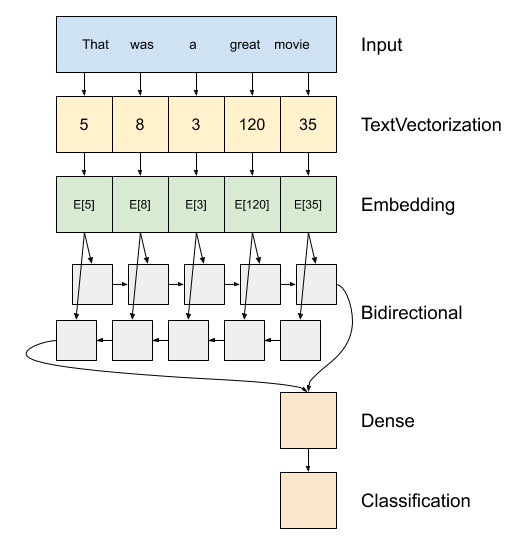


Using the keras _Sequential_ the model can be build by stacking up layers linearly:

Types of layers:
* **Encoder** (keras.layers.TextVectorization): it converts the input text to a **sequence of token indices**. 
* **Embedding**: assigns to each word a vector, converting the sequence of word indices to a sequence of vectors, which can be trained. (similar words often have similar vectors) It
takes as argument an integer-encoded vocabulary of the size _vocab_size_ and a vector dimension, and the output of this layer is : (batch, sequence, embedding).
* **Dropout**: drop some of the nodes to prevent overfitting. Takes as argument a threshold value which represents the probability above which the nodes have to be dropped.
* **Pooling** (GlobalAveragingPooling1D): returns a fixed-length vector by re-computing the average over the dimension of the sequences to be able to handle input of variable length and without losing information.
* **Bidirectional**: propagates the input forward and backward (feedback) between the RNN layers, then it concatenates the result. The main advantage of an additional Bidirectional layer is that it can take into consideration the past, present and future events when making a prediction. This makes it useful for the several text prediction or speech recognition systems, where the surrounding context has to be known in order to predict the current output.
* **Dense** (classification layer): input arguments are the nr of neurons in the hidden respectively the output layers and the activation function.

Activation functions:
* Hidden layers 

  -> ReLU: keeps the original weighted sum of the positive inputs. If the input is positive, then it returns it as it is (without saturing it), but if the input is negative it will return 0 instead.
* Output layer 

  -> Sigmoid: maps the output value to a probability, in the interval [0,1]. In case of the binary classification problem, an output above a given threshold, say 0.5 means positive response, while a value below 0.5 is classified as negative.

  -> Softmax: it maps the non-normalized output of data to the probability distribution for output classes. All output elements will be in the range [0,1] and they will sum up to 1. The larger the input number the larger the value of the output probabilities will be.

  The difference between the two activation functions is that the Sigmoid is used for binary classification, while the Softmax is used for multi-classification in the Logistic Regression model. 
  
  Another difference, is that the outputs of a sigmoid function are independent, while in case of the softmax they are related to each other, because of the constraint that they must sum up to 1.

  When using a **sigmoid** activation function, for a binary predictor, like in this example, there is only 1 output neuron, which can be either 1 indicating a positive sentiment or 0 which means a negative sentiment.

  If using a **softmax** activation function, the final dense layer will have 2 neurons and the softmax determines the probability of inclining towards either the positive or negative label.

Build the model adding layers to it:

In [189]:
vocab_size = 10000
max_sequence_length = 256

# add a sequential layer for grouping the other linear layers
model = Sequential()
# add an embedding layer for processing the input text
model.add(Embedding(input_dim = vocab_size, output_dim = 16))
# averaging pool layer
model.add(GlobalAveragePooling1D())
# hidden layer
model.add(Dense(16, activation = 'relu'))
# output layer consisting of only 1 neuron for binary prediction
model.add(Dense(1, activation = 'sigmoid'))

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, None, 16)          160000    
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense_16 (Dense)            (None, 16)                272       
                                                                 
 dense_17 (Dense)            (None, 1)                 17        
                                                                 
Total params: 160,289
Trainable params: 160,289
Non-trainable params: 0
_________________________________________________________________


Compile the model by specifying the loss function and optimizer to use. Additionally, the evaluation metrics can also be specified:

In [190]:
model.compile(loss="binary_crossentropy",
 optimizer="adam",
 metrics=["accuracy"])

Training and evaluating the model:

Define a function for plotting the results (loss, evaluation metrics) as the epochs evolve:

In [191]:
def plot_epochs(history):
  """
    Plots the values of loss and the specified evaluation metric along the epochs.
  """
  pd.DataFrame(history.history).plot(figsize=(8, 5))
  plt.grid(True)
  plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
  plt.show()

Train the model on a training set (specify the number of epochs to train) and evaluate it on the validation set.

In [192]:
history = model.fit(X_train, y_train, batch_size = 16, epochs = 60, validation_data=(X_val, y_val), verbose = 1)

Epoch 1/60
56/56 [==============================] - 1s 7ms/step - loss: 0.6919 - accuracy: 0.5190 - val_loss: 0.6905 - val_accuracy: 0.5100
Epoch 2/60
56/56 [==============================] - 0s 5ms/step - loss: 0.6797 - accuracy: 0.6763 - val_loss: 0.6796 - val_accuracy: 0.5400
Epoch 3/60
56/56 [==============================] - 0s 5ms/step - loss: 0.6462 - accuracy: 0.7612 - val_loss: 0.6584 - val_accuracy: 0.5600
Epoch 4/60
56/56 [==============================] - 0s 5ms/step - loss: 0.5730 - accuracy: 0.8002 - val_loss: 0.6308 - val_accuracy: 0.5700
Epoch 5/60
56/56 [==============================] - 0s 5ms/step - loss: 0.4816 - accuracy: 0.8170 - val_loss: 0.6137 - val_accuracy: 0.5600
Epoch 6/60
56/56 [==============================] - 0s 5ms/step - loss: 0.4159 - accuracy: 0.8136 - val_loss: 0.6166 - val_accuracy: 0.5600
Epoch 7/60
56/56 [==============================] - 0s 5ms/step - loss: 0.3787 - accuracy: 0.8080 - val_loss: 0.6185 - val_accuracy: 0.5600
Epoch 8/60
56/56 [==

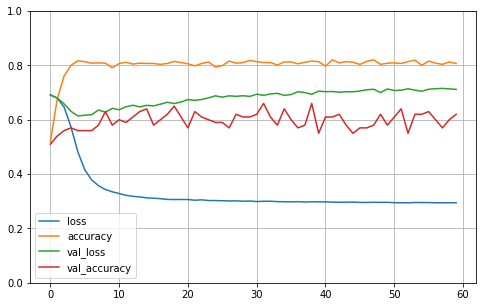

In [193]:
plot_epochs(history)

In [194]:
results = model.evaluate(X_test, y_test)

7/7 [==============================] - 0s 2ms/step - loss: 0.5331 - accuracy: 0.7150


Define a function for reconstructing the original text before the vectorization process (based on the word_index):

In [195]:
def decode_text(text, word_index):
    """
      Decode the sequence of word indices using the given word_index which contains all the unique tokens and their associated index values.
      Return the original text phrase.
    """
    # build a reverse word index
    reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
    # reconstruct the original sentence by mapping the indices to their text values
    return " ".join([reverse_word_index.get(i, '?') for i in text])

Use the model to predict the output labels for the test dataset:

In [196]:
pred_example = X_test.iloc[10:20]
pred_label = y_test.iloc[10:20]
print("Original text: \n", decode_text(pred_example, word_index))
print("Predicted probability: \n", model.predict(pred_example))

Original text: 
 ? ? may ? ? menu rick ? recommend textur
Predicted probability: 
 [[0.5609822 ]
 [0.44805366]
 [0.00448748]
 [0.00323898]
 [0.79187137]
 [0.3175219 ]
 [0.9460579 ]
 [0.5095758 ]
 [0.33854994]
 [0.9997835 ]]


Finally, save the model:

In [197]:
output_loc = 'results/model_1'
model.save(output_loc)

INFO:tensorflow:Assets written to: results/model_1/assets


INFO:tensorflow:Assets written to: results/model_1/assets


*Remark: Loading back the model from the specified location by:

In [198]:
model = keras.models.load_model(output_loc)
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, None, 16)          160000    
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense_16 (Dense)            (None, 16)                272       
                                                                 
 dense_17 (Dense)            (None, 1)                 17        
                                                                 
Total params: 160,289
Trainable params: 160,289
Non-trainable params: 0
_________________________________________________________________


In [199]:
# vocab_size = 1000
# max_sequence_length = 256

# model = Sequential()
# # add an embedding layer for 
# model.add(Embedding(input_dim = vocab_size, output_dim = 64, input_length = max_sequence_length - 1))
# model.add(Conv1D(32, (1), padding='same', activation='relu'))
# model.add(Conv1D(32, (1), activation='relu'))
# model.add(Dropout(0.5)) 

# model.add(Conv1D(64, (1), padding='same', activation='relu'))
# model.add(Conv1D(64, (1), activation='relu'))
# model.add(Dropout(0.5)) 

# model.add(Bidirectional(LSTM(64)))
# model.add(Dense(vocab_size, activation = 'softmax'))
# model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['acc'])
# history = model.fit(X_train, y_train, epochs = 10, validation_data=(X_val, y_val), verbose = 1)

# Text Classification with RNN steps:

1. Prepare and split the dataset

In [224]:
# split the dataset into training and test sets in 8/2 ratio
train_data = raw_data.sample(frac=0.8, replace=True, random_state=1)
test_data = raw_data.drop(train_data.index)

# convert the pandas dataframes into tensorflow datasets
tf_train = wrap_tf_dataset(train_data)
tf_test = wrap_tf_dataset(test_data)

 2. Build the model

In [228]:
# create and apply the encoder on the train dataset
encoder = text_vectorization_layer(tf_train, VOCAB_SIZE, max_sequence_length)

# build the model
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=1000,
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

2.1. Verify that the result of prediction remains the same for both padded and not padded input sequence.

In [229]:
sample_text = ('The food was good. The atmosphere and the customer service were excellent. I would recommend this restaurant.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

[-0.0011534]


In [230]:
padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

[-0.0011534]


3. Configure the model

In [231]:
# configure and compile the model
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

4. Train the model

In [233]:
history = model.fit(tf_train, 
                    batch_size=32,
                    epochs=10,
                    validation_data=tf_test)

Epoch 1/10
16/16 [==============================] - 25s 857ms/step - loss: 0.6933 - accuracy: 0.4990 - val_loss: 0.6924 - val_accuracy: 0.4990
Epoch 2/10
16/16 [==============================] - 10s 650ms/step - loss: 0.6920 - accuracy: 0.4990 - val_loss: 0.6915 - val_accuracy: 0.4990
Epoch 3/10
16/16 [==============================] - 10s 635ms/step - loss: 0.6911 - accuracy: 0.4990 - val_loss: 0.6905 - val_accuracy: 0.4990
Epoch 4/10
16/16 [==============================] - 10s 641ms/step - loss: 0.6900 - accuracy: 0.4990 - val_loss: 0.6892 - val_accuracy: 0.4990
Epoch 5/10
16/16 [==============================] - 10s 628ms/step - loss: 0.6885 - accuracy: 0.4990 - val_loss: 0.6874 - val_accuracy: 0.4990
Epoch 6/10
16/16 [==============================] - 10s 629ms/step - loss: 0.6865 - accuracy: 0.4990 - val_loss: 0.6850 - val_accuracy: 0.4990
Epoch 7/10
16/16 [==============================] - 10s 634ms/step - loss: 0.6836 - accuracy: 0.4990 - val_loss: 0.6813 - val_accuracy: 0.4990

5. Evaluate the model

In [206]:
test_loss, test_acc = model.evaluate(tf_test)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

16/16 [==============================] - 2s 126ms/step - loss: 0.6268 - accuracy: 0.5060
Test Loss: 0.6267788410186768
Test Accuracy: 0.5060241222381592


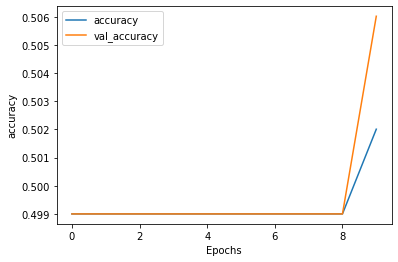

In [207]:
plot_graphs(history,'accuracy')

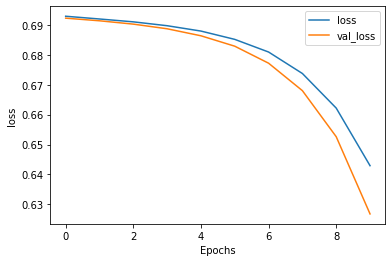

In [208]:
plot_graphs(history,'loss')

Test prediction of an example sentence:

Positive predicted value indicates a positive sentiment, while
negative value represents a negative sentiment.

In [209]:
positive_example = ('The food was good. The atmosphere and the customer service were excellent. I would recommend this restaurant.')
print("positive example prediction: ",model.predict(np.array([positive_example])))

negative_example = ('The food was bad. The atmosphere and the customer service were awful. I would not recommend this restaurant.')
print("negative example prediction: ",model.predict(np.array([negative_example])))

positive example prediction:  [[0.4659654]]
negative example prediction:  [[0.19360234]]


As we can see the model correctly predicted that the first example review had a positive sentiment, while the second a negative one.

In [210]:
output_loc = 'results/model_2'
model.save(output_loc)

INFO:tensorflow:Assets written to: results/model_2/assets


INFO:tensorflow:Assets written to: results/model_2/assets


Combining all the previous steps and testing it using the custom preprocessing/standardization function for cleaning the data:

In [239]:
def prediction_with_RNN(raw_data, custom_standardization, embedding_out_dim, layers, model_name):
    # Prepare and split the dataset
    train_data = raw_data.sample(frac=0.8, replace=True, random_state=1)
    test_data = raw_data.drop(train_data.index)

    tf_train = wrap_tf_dataset(train_data)
    tf_test = wrap_tf_dataset(test_data)

    # get the size of the vocabulary
    vocab_size = raw_data.shape[0]

    # create and apply the encoder on the train dataset
    encoder = text_vectorization_layer(tf_train, vocab_size, max_sequence_length, custom_standardization)

    # build the model
    model = tf.keras.Sequential(
            # add the encoder layer to the model
            encoder,
            # add an embedding layer as well
            tf.keras.layers.Embedding(
                input_dim = vocab_size,
                output_dim = embedding_out_dim,
                # Use masking to handle the variable sequence lengths
                mask_zero=True))
    # add the rest of the layers
    for layer in layers:
      model.add(layer)

    # configure and compile the model
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  optimizer=tf.keras.optimizers.Adam(1e-4),
                  metrics=['accuracy'])
    
    # train the model
    history = model.fit(tf_train, 
                    batch_size=32,
                    epochs=10,
                    validation_data=tf_test)

    # evaluate the model
    test_loss, test_acc = model.evaluate(tf_test)
    print('Test Loss:', test_loss)
    print('Test Accuracy:', test_acc)

    # plot graphs
    plot_graphs(history,'accuracy')
    plot_graphs(history,'loss')

    # save the model
    output_loc = 'results/'+model_name
    model.save(output_loc)

In [241]:
layers = [
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
]


prediction_with_RNN(raw_data, custom_standardization=False, embedding_out_dim=64, layers=layers, model_name="custom_model")

ValueError: ignored